In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# modeling
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

# importing scripts
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
from scripts import preprocessing_yellow

In [3]:
df = preprocessing_yellow.clean_yellow_taxi_df('../data', 2023, 1)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min,PU_Borough,DO_Borough
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333,Manhattan,Manhattan
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.316667,Manhattan,Manhattan
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.0,12.750000,Manhattan,Manhattan
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.833333,Manhattan,Manhattan
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.300000,Manhattan,Manhattan


# Data Preparation

The data has undergone preprocessing and cleaning, with additional details about the specific method used provided in the "preprocessing_yellow.py" script. The objective of this data preparation stage is to develop a model capable of accurately predicting the number of trips in specific areas. This prediction will aid in optimizing driver allocation for efficient service provision.

To initiate the analysis, we will first explore the data by grouping it at a high level based on boroughs. This grouping will help provide insights into the distribution of trips across different areas and serve as a foundation for further analysis and modeling.

In [6]:
def sin_cos_transformation(df, column, period):
    value = 2*np.pi*df[column]/period
    features = {
        f'sin_{column}': lambda x: np.sin(value),
        f'cos_{column}': lambda x: np.cos(value),
    }
    return df.assign(**features)

def log_transform(df, column):
    df[column] = np.log(df[column] + 1)
    return df

df_grouped = (
    df
    # counting number of trips per hour in each district
    .groupby([
        pd.Grouper(key='tpep_pickup_datetime', axis=0, freq='H'), 
        'PU_Borough',
    ]) 
    .size().reset_index().rename(columns={0: 'num_of_trips'})
    # feature engineering, adding columns that represent the cyclic behaviour of hours and days of week
    .assign(
        hour=lambda x: x['tpep_pickup_datetime'].dt.hour,
        day_of_week=lambda x: x['tpep_pickup_datetime'].dt.day_of_week,
    )
    .pipe(sin_cos_transformation, column='hour', period=24)
    .pipe(sin_cos_transformation, column='day_of_week', period=7)
    # Also as manhattan has greater traffic it will be easier to inspect and predict this data on a log scale
    .pipe(log_transform, column='num_of_trips')
)
df_grouped.to_parquet('../sample_data/num_of_trips.parquet')
df_grouped

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Bronx,1.386294,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Brooklyn,3.637586,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 00:00:00,EWR,0.000000,0,6,0.000000,1.000000,-0.781831,0.62349
3,2023-01-01 00:00:00,Manhattan,8.399535,0,6,0.000000,1.000000,-0.781831,0.62349
4,2023-01-01 00:00:00,Queens,5.572154,0,6,0.000000,1.000000,-0.781831,0.62349
...,...,...,...,...,...,...,...,...,...
4459,2023-01-31 23:00:00,Brooklyn,2.564949,23,1,-0.258819,0.965926,0.781831,0.62349
4460,2023-01-31 23:00:00,EWR,0.000000,23,1,-0.258819,0.965926,0.781831,0.62349
4461,2023-01-31 23:00:00,Manhattan,7.642524,23,1,-0.258819,0.965926,0.781831,0.62349
4462,2023-01-31 23:00:00,Queens,5.564520,23,1,-0.258819,0.965926,0.781831,0.62349


# Exploration to see if there are any problems with data

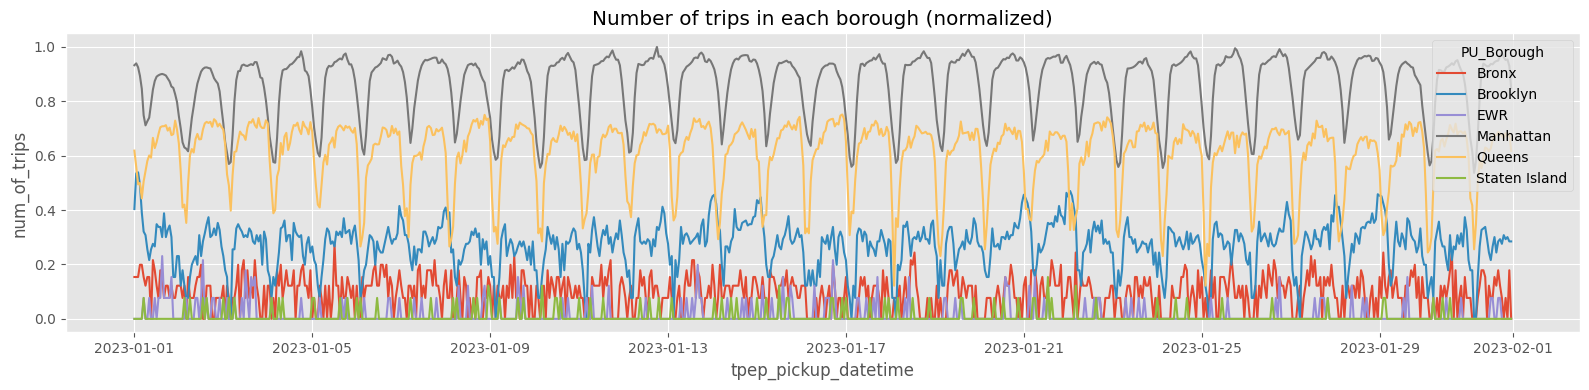

In [7]:
transformers = ColumnTransformer([
    ('pass', 'passthrough', ['tpep_pickup_datetime', 'PU_Borough']),
    ('min_max_scaling', MinMaxScaler(), ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

pipe = Pipeline([
    ('transformers', transformers)
])


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.lineplot(pipe.fit_transform(df_grouped), x='tpep_pickup_datetime', y='num_of_trips', hue='PU_Borough', ax=ax)
ax.set_title('Number of trips in each borough (normalized)')
fig.tight_layout()

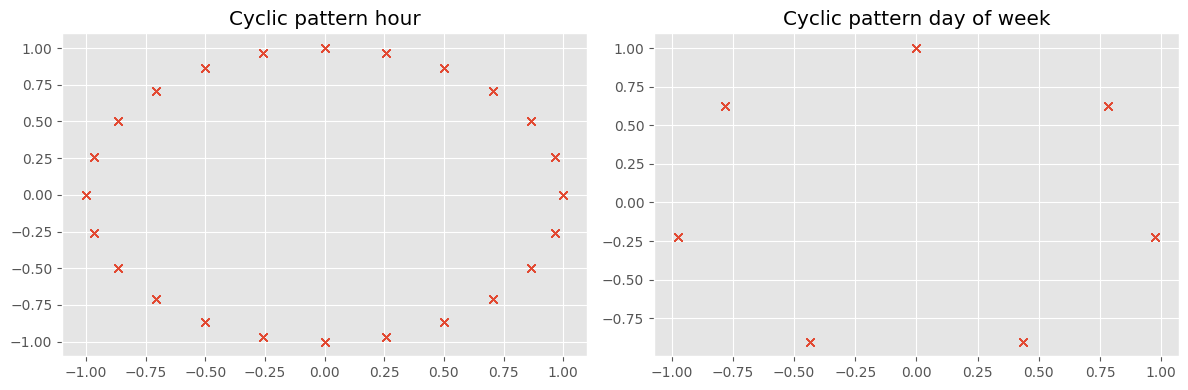

In [8]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 4))
ax[0].plot(df_grouped['sin_hour'], df_grouped['cos_hour'], 'x'), ax[1].plot(df_grouped['sin_day_of_week'], df_grouped['cos_day_of_week'], 'x')
ax[0].set_title('Cyclic pattern hour'), ax[1].set_title('Cyclic pattern day of week')
fig.tight_layout()

Considering the relatively low number of trips in areas other than Manhattan, Queens, and Brooklyn, which are the main operating areas for Yellow taxis, those areas will be excluded from the analysis for now to prevent potential performance issues in predictive models. These areas are primarily served by Green taxis.

For modeling purposes, the data will be split into separate training and testing datasets based on the pickup date:

- The training dataset will comprise data from days 1 to 21.
- The testing dataset will include data from days 22 to 31.

In [9]:
df_grouped = (
    # limiting data to only two districts
    df_grouped[df_grouped['PU_Borough'].isin(['Manhattan', 'Queens', 'Brooklyn'])]
    # recasting datatype (seaborn still shows old districts using pd.cat.categories)
    .astype({'PU_Borough': 'object'}).astype({'PU_Borough': 'category'})
    .reset_index(drop=True)
)

# split condition
condition = df_grouped['tpep_pickup_datetime'] < '2023-01-22'
df_train, df_test = df_grouped[condition], df_grouped[~condition]
display(df_train.head(4), df_test.head(4))

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Brooklyn,3.637586,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Manhattan,8.399535,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 00:00:00,Queens,5.572154,0,6,0.000000,1.000000,-0.781831,0.62349
3,2023-01-01 01:00:00,Brooklyn,4.820282,1,6,0.258819,0.965926,-0.781831,0.62349


,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
1512,2023-01-22 00:00:00,Brooklyn,4.043051,0,6,0.000000,1.000000,-0.781831,0.62349
1513,2023-01-22 00:00:00,Manhattan,8.549660,0,6,0.000000,1.000000,-0.781831,0.62349
1514,2023-01-22 00:00:00,Queens,4.828314,0,6,0.000000,1.000000,-0.781831,0.62349
1515,2023-01-22 01:00:00,Brooklyn,4.234107,1,6,0.258819,0.965926,-0.781831,0.62349


<Axes: xlabel='day_of_week', ylabel='num_of_trips'>

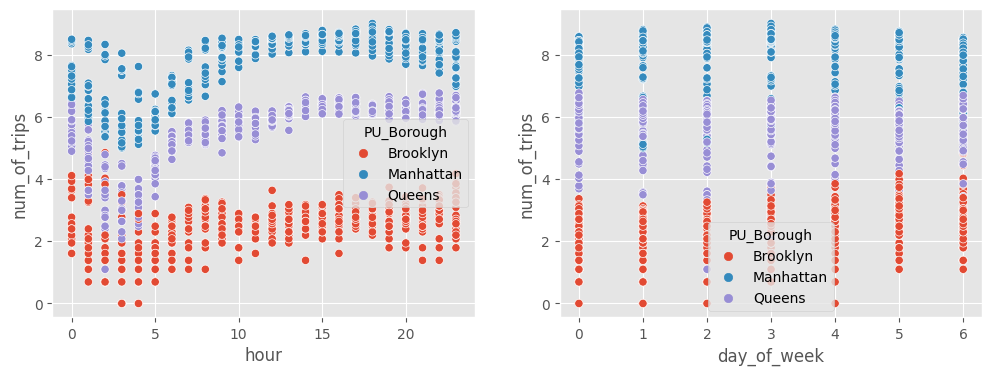

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(df_train,  x='hour', y='num_of_trips', hue='PU_Borough', ax=ax[0])
sns.scatterplot(df_train,  x='day_of_week', y='num_of_trips', hue='PU_Borough', ax=ax[1])

<Axes: xlabel='num_of_trips', ylabel='Count'>

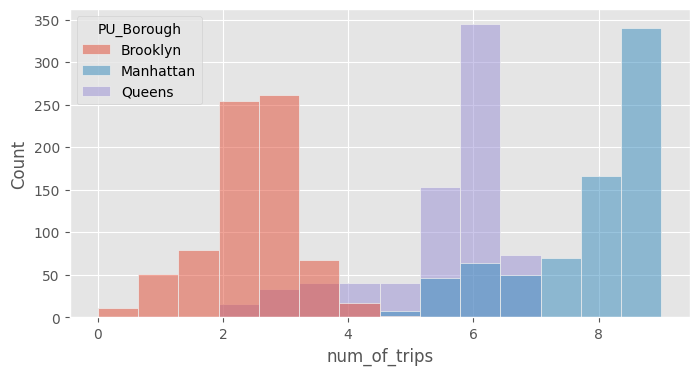

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(x=df_grouped['num_of_trips'], hue=df_grouped['PU_Borough'])

# Linear regression

In [32]:
transformers = ColumnTransformer([
    # onehot encoding borough
    ('encode_borough', OneHotEncoder(sparse_output=False), ['PU_Borough']),
    # normalizing target variable to 0 to 1 scale
    ('normalize_target', MinMaxScaler(), ['num_of_trips']),
    # no need to process sin/cos features as they are on -1 to 1 scale
    ('pass', 'passthrough', ['sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

data_processing_pipe = Pipeline([
    ('transformers', transformers),
])

df_train_processed = data_processing_pipe.fit_transform(df_train)
X_features = [i for i in df_train_processed.columns if i != 'num_of_trips']
target = ['num_of_trips']
X_train, y_train = df_train_processed[X_features], df_train_processed[target]
df_test_processed = data_processing_pipe.transform(df_test)
X_test, y_test = df_test_processed[X_features], df_test_processed[target]

In [33]:
models = [
    ('lr_l2', Ridge(), {
        'alpha': np.linspace(0, 10, 20)
    }),
    ('tree_regressor', DecisionTreeRegressor(random_state=789), {
        'max_depth': [1, 2, 5, 10, 20, 30, None],
        'min_samples_split': np.linspace(2, 11, dtype=np.int8),
        'min_samples_leaf': np.linspace(1, 11, dtype=np.int8),
        # 'min_impurity_decrease': np.linspace(0, 11, dtype=np.float16),
        # 'ccp_alpha': np.linspace(0, 11, dtype=np.float16),
    }),
]
trained_models = {}

for model_name, model, param_grid in models:
    cv = RandomizedSearchCV(model, param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=888).fit(X_train, y_train)
    trained_models[model_name] = clone(cv.best_estimator_).fit(X_train, y_train)
    print(f'Model: {model_name},\tBest model score: {round(cv.best_score_, 3)},\tBest model parameters: {cv.best_params_}')

Model: lr_l2,	Best model score: -0.006,	Best model parameters: {'alpha': 0.0}
Model: tree_regressor,	Best model score: -0.002,	Best model parameters: {'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 20}


## Inspecting model prediction

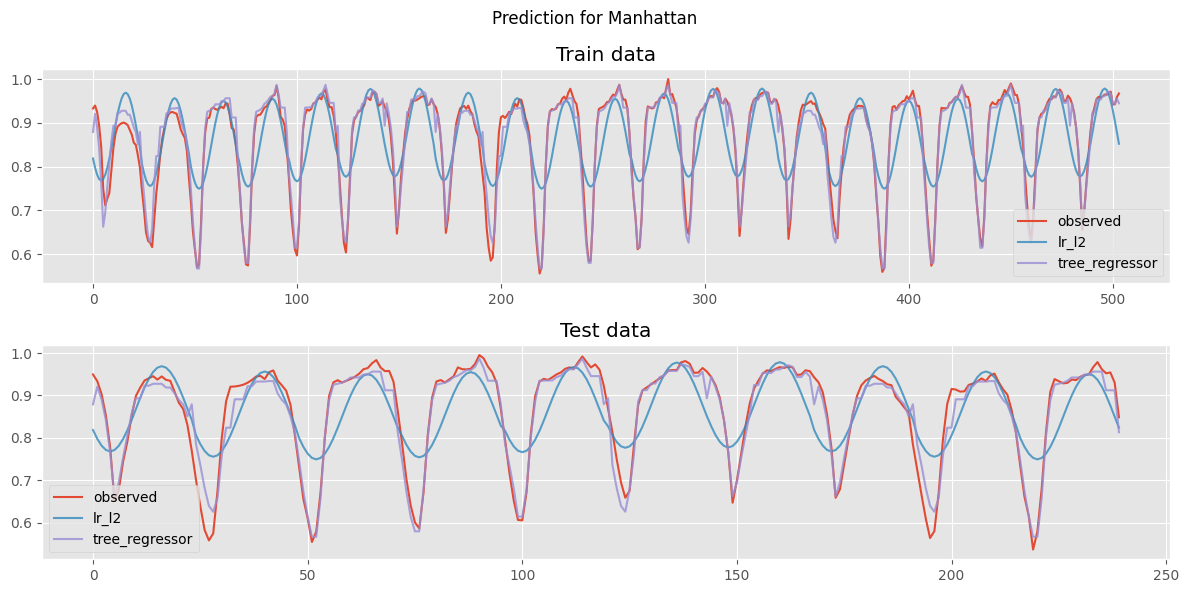

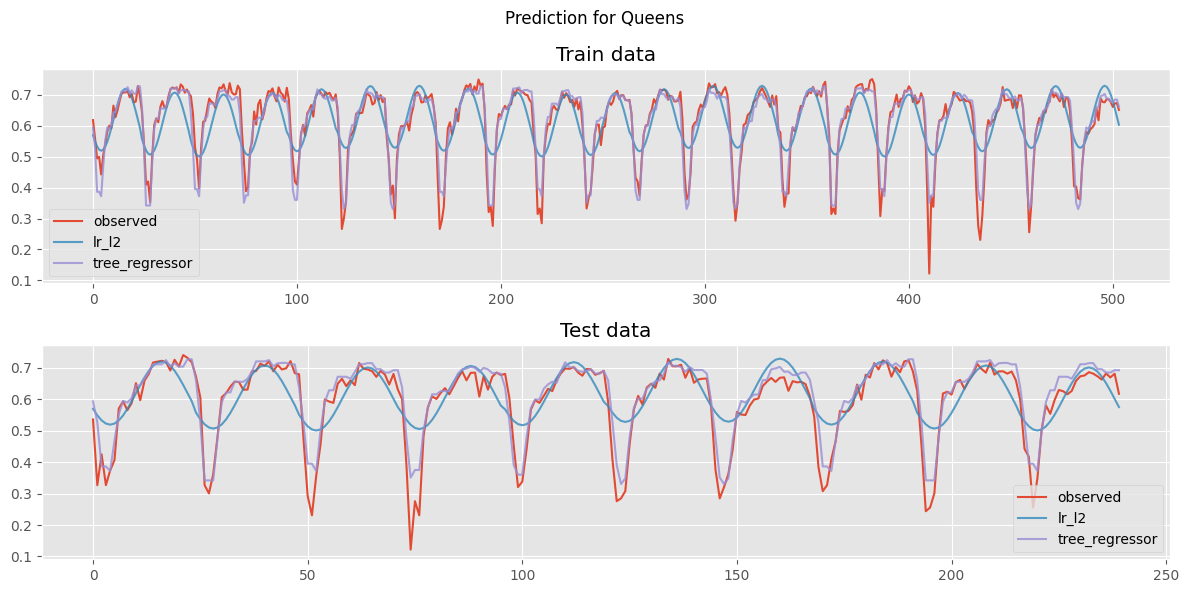

In [34]:
def plot_for_borough(borough):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    for idx, data in enumerate([df_train, df_test]):
        # dataset fragment on Manhattan data
        data_borough = data_processing_pipe.transform(data[data['PU_Borough'] == borough])
        y_true = data_borough[target].reset_index(drop=True)

        ax[idx].plot(y_true)
        for key in trained_models.keys():
            y_prediction = trained_models[key].predict(data_borough[X_features])
            ax[idx].plot(y_prediction, alpha=.8)

        ax[idx].legend(['observed', *trained_models.keys()])

    ax[0].set_title('Train data'), ax[1].set_title('Test data'), 
    fig.suptitle(f'Prediction for {borough}')
    fig.tight_layout()

plot_for_borough('Manhattan')
plot_for_borough('Queens')

The simple tree regressor performs well for both boroughs, while the linear model fails in both cases. It seems that a linear model in a simple linear fashion would require an interaction term to account for the complexities present. Additionally, I plan to test the effectiveness of full categorical encoding on the data.

## Linear full categorical encoding

In [35]:
transformers = ColumnTransformer([
    # onehot encoding borough
    ('encode_borough', OneHotEncoder(sparse_output=False), ['PU_Borough', 'hour', 'day_of_week']),
    # normalizing target variable to 0 to 1 scale
    ('normalize_target', MinMaxScaler(), ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

data_processing_pipe = Pipeline([
    ('transformers', transformers),
])

df_train_processed = data_processing_pipe.fit_transform(df_train)
X_features = [i for i in df_train_processed.columns if i != 'num_of_trips']
target = ['num_of_trips']
X_train, y_train = df_train_processed[X_features], df_train_processed[target]
df_test_processed = data_processing_pipe.transform(df_test)
X_test, y_test = df_test_processed[X_features], df_test_processed[target]

In [36]:
models = [
    ('lr_l2', Ridge(), {
        'alpha': np.linspace(0, 10, 20)
    }),
    ('tree_regressor', DecisionTreeRegressor(random_state=789), {
        'max_depth': [1, 2, 5, 10, 20, 30, None],
        'min_samples_split': np.linspace(2, 11, dtype=np.int8),
        'min_samples_leaf': np.linspace(1, 11, dtype=np.int8),
        # 'min_impurity_decrease': np.linspace(0, 11, dtype=np.float16),
        # 'ccp_alpha': np.linspace(0, 11, dtype=np.float16),
    }),
]
trained_models = {}

for model_name, model, param_grid in models:
    cv = RandomizedSearchCV(model, param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=888).fit(X_train, y_train)
    trained_models[model_name] = clone(cv.best_estimator_).fit(X_train, y_train)
    print(f'Model: {model_name},\tBest model score: {round(cv.best_score_, 3)},\tBest model parameters: {cv.best_params_}')

Model: lr_l2,	Best model score: -0.004,	Best model parameters: {'alpha': 0.5263157894736842}
Model: tree_regressor,	Best model score: -0.002,	Best model parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}


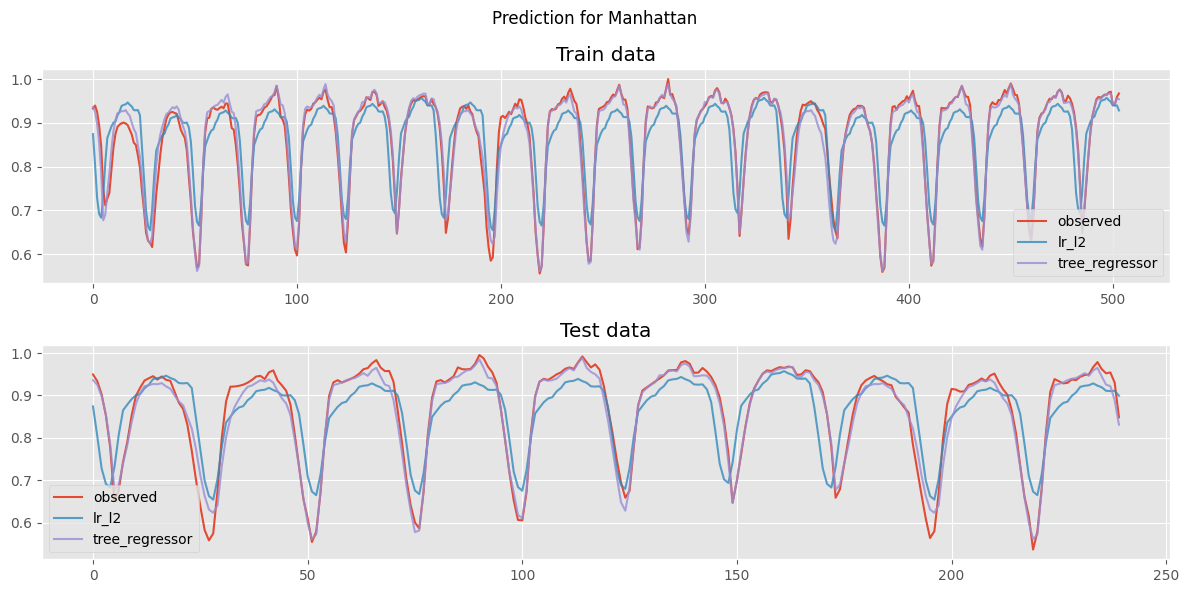

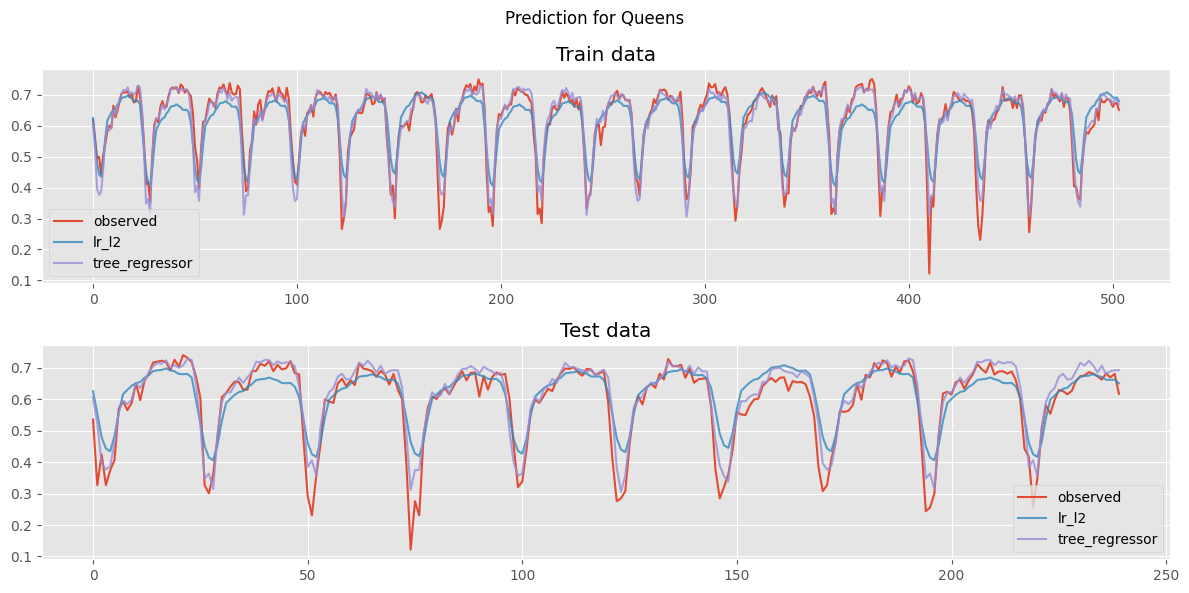

In [37]:
plot_for_borough('Manhattan')
plot_for_borough('Queens')

But going with this type of model, where we don't use the cyclic variables work so much better, I guess this is for a reason more of a deep learning approach. More on this problem can be found in the Bayesian notebook